<a href="https://colab.research.google.com/github/LucyLightCode/Mayfair_project_sentiment_analysis/blob/main/mayfair_sentiment_analysis_proj_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORT LIBRARIES & PACKAGES

In [ ]:
!pip install emoji

In [ ]:
!pip install langdetect

In [ ]:
!pip install contractions

In [ ]:
!pip install googletrans==4.0.0-rc1

In [ ]:
!pip install xgboost imbalanced-learn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import emoji
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from googletrans import Translator
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
nltk.download('punkt_tab', download_dir='/root/nltk_data')
nltk.download('wordnet', download_dir='/root/nltk_data')
nltk.download('omw-1.4', download_dir='/root/nltk_data')
nltk.download('stopwords', download_dir='/root/nltk_data')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## LOAD THE DATASET

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Mayfair_Project/combined_reviews_dataset.csv')

In [ ]:
df.head(10)

,REVIEW_ID,REVIEW_CONTENT,RATING,DATE,COUNTRY
0,6.01E+16,"Same to this one as well, very classy and soft...",5.0,11/8/2024,United States
1,6.01E+16,"Beautiful colors, exactly what I wanted, but ...",4.0,10/15/2024,United States
2,6.01E+16,"This is top notch scarf, so soft and classy no...",5.0,11/8/2024,United States
3,6.01E+16,Item was great; would buy from seller again!,5.0,11/10/2024,United States
4,6.01E+16,Nice item,5.0,10/1/2024,United States
5,6.01E+16,Beautiful scarf🧣Beautiful scarf🧣Beautiful scar...,5.0,10/24/2024,United States
6,5.02E+16,The scarf color is neatly and the material is ...,5.0,11/4/2024,United States
7,6.01E+16,"Very cute super soft, the fabric is Silk",5.0,10/31/2024,United States
8,6.01E+16,👍💯💥💝🤩💚💖❤️‍🔥💙🎶😎 great toile bandana style,5.0,10/3/2024,United States
9,6.01E+16,"Just as pictured, fast shipping, very satisfied",5.0,10/12/2024,United States


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12822 entries, 0 to 12821
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   REVIEW_ID       12820 non-null  object 
 1   REVIEW_CONTENT  12078 non-null  object 
 2   RATING          12457 non-null  float64
 3   DATE            12808 non-null  object 
 4   COUNTRY         12822 non-null  object 
dtypes: float64(1), object(4)
memory usage: 501.0+ KB


In [ ]:
df.isnull().sum()

,0
REVIEW_ID,2
REVIEW_CONTENT,744
RATING,365
DATE,14
COUNTRY,0


In [ ]:
df.duplicated().sum()

np.int64(265)

In [ ]:
df.nunique()

,0
REVIEW_ID,10311
REVIEW_CONTENT,11611
RATING,5
DATE,2422
COUNTRY,110


In [ ]:
df.describe(include='all')  # Includes numerical and categorical columns

,REVIEW_ID,REVIEW_CONTENT,RATING,DATE,COUNTRY
count,12820,12078,12457.000000,12808,12822
unique,10311,11611,NaN,2422,110
top,3.01E+16,Good,NaN,3/24/2025,United Kingdom
freq,1054,39,NaN,143,4381
mean,NaN,NaN,3.534960,NaN,NaN
std,NaN,NaN,1.509524,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN
25%,NaN,NaN,2.000000,NaN,NaN
50%,NaN,NaN,4.000000,NaN,NaN
75%,NaN,NaN,5.000000,NaN,NaN


#  EDA

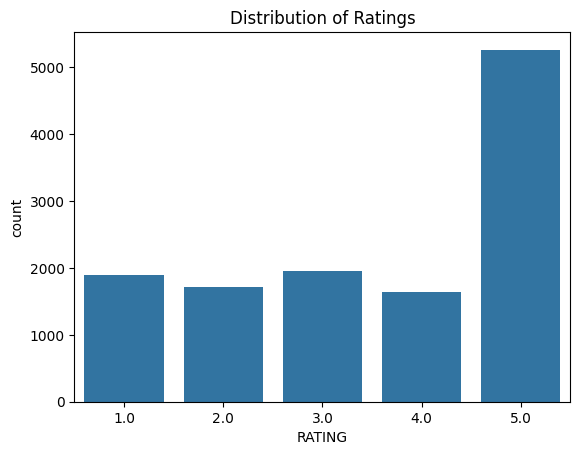

In [ ]:
# Understand the frequency of each rating score
sns.countplot(x='RATING', data=df)
plt.title('Distribution of Ratings')
plt.show()

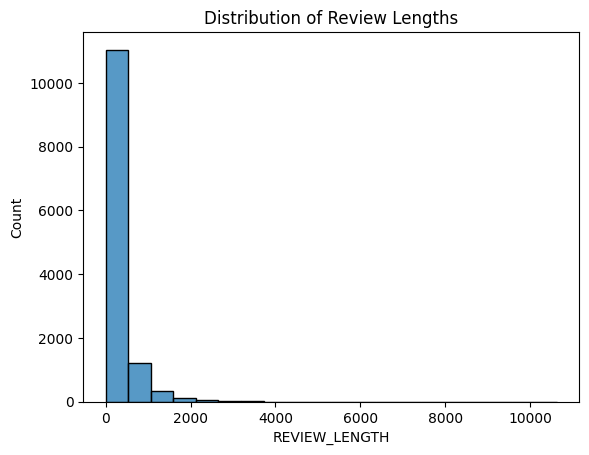

In [ ]:
#Explore the length of reviews and potential relationship with ratings.
df['REVIEW_LENGTH'] = df['REVIEW_CONTENT'].astype(str).apply(len)
sns.histplot(df['REVIEW_LENGTH'], bins=20)
plt.title('Distribution of Review Lengths')
plt.show()

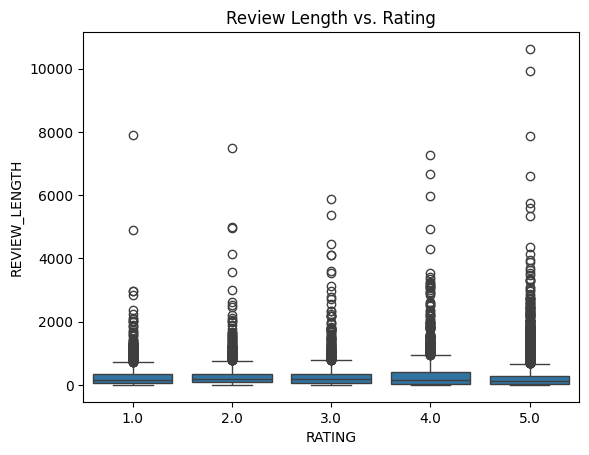

In [ ]:
# Relationship between review length and rating
sns.boxplot(x='RATING', y='REVIEW_LENGTH', data=df)
plt.title('Review Length vs. Rating')
plt.show()

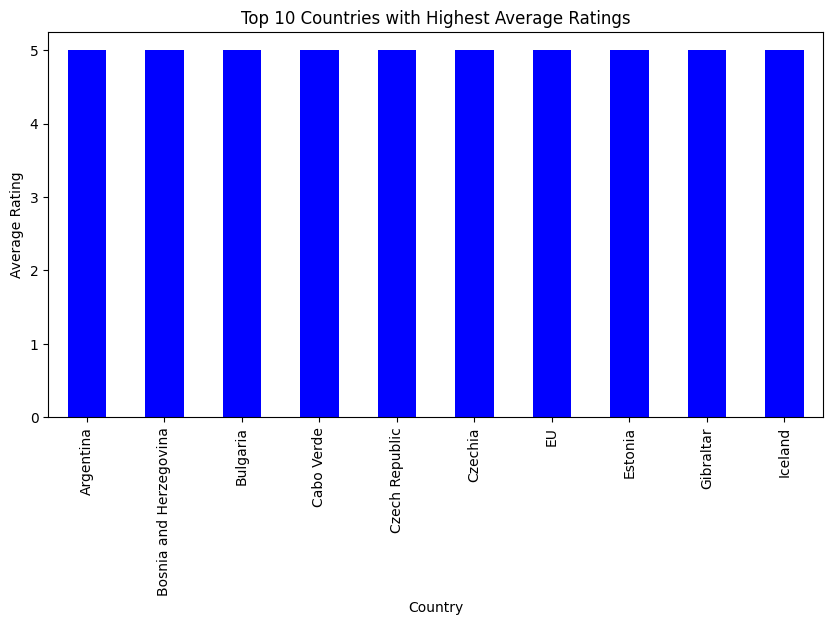

In [ ]:
# Top 5 countries with highest ratings
top_10_highest = df.groupby('COUNTRY')['RATING'].mean().nlargest(10)
plt.figure(figsize=(10, 5))
top_10_highest.plot(kind='bar', color='blue')
plt.title('Top 10 Countries with Highest Average Ratings')
plt.xlabel('Country')
plt.ylabel('Average Rating')
plt.show()

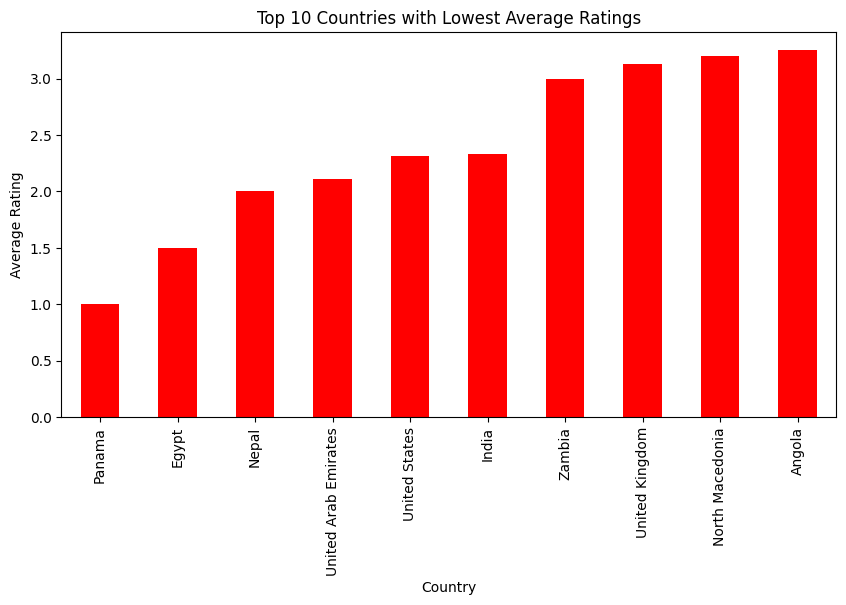

In [ ]:
# Top 5 countries with lowest ratings
top_10_lowest = df.groupby('COUNTRY')['RATING'].mean().nsmallest(10)
plt.figure(figsize=(10, 5))
top_10_lowest.plot(kind='bar', color='red')
plt.title('Top 10 Countries with Lowest Average Ratings')
plt.xlabel('Country')
plt.ylabel('Average Rating')
plt.show()

In [ ]:
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')  # Convert to datetime, handling errors
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y', errors='coerce') #If '%m/%d/%Y' is expected
df['YEAR'] = df['DATE'].dt.year

In [ ]:
#df['DATE'] = pd.to_datetime(df['DATE'])  # Convert to datetime
#df['YEAR'] = df['DATE'].dt.year

In [ ]:
yearly_data = df.groupby('YEAR').agg(
    AVERAGE_RATING=('RATING', 'mean'),
    REVIEW_COUNT=('REVIEW_CONTENT', 'count')
).reset_index()

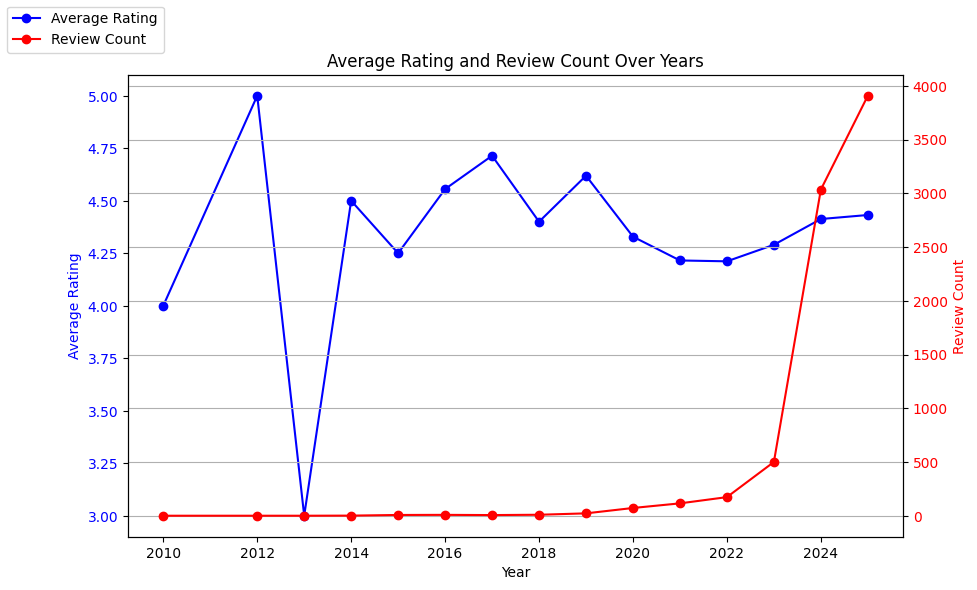

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average rating
ax1.plot(yearly_data['YEAR'], yearly_data['AVERAGE_RATING'], color='blue', label='Average Rating',marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Rating', color='blue')
ax1.tick_params('y', labelcolor='blue')

# Create a second y-axis for review count
ax2 = ax1.twinx()
ax2.plot(yearly_data['YEAR'], yearly_data['REVIEW_COUNT'], color='red', label='Review Count',marker='o')
ax2.set_ylabel('Review Count', color='red')
ax2.tick_params('y', labelcolor='red')

# Add title and legend
plt.title('Average Rating and Review Count Over Years')
fig.legend(loc='upper left')
plt.grid(True)

plt.show()

## DATA CLEANING & PREPROCESSING

In [ ]:
# Rename columns correctly
df = df.rename(columns={'REVIEW_CONTENT': 'content', 'RATING': 'rating'})

# Subset only the relevant columns
df = df[['content', 'rating']]

# Display the first few rows
df.head(10)

,content,rating
0,"Same to this one as well, very classy and soft...",5.0
1,"Beautiful colors, exactly what I wanted, but ...",4.0
2,"This is top notch scarf, so soft and classy no...",5.0
3,Item was great; would buy from seller again!,5.0
4,Nice item,5.0
5,Beautiful scarf🧣Beautiful scarf🧣Beautiful scar...,5.0
6,The scarf color is neatly and the material is ...,5.0
7,"Very cute super soft, the fabric is Silk",5.0
8,👍💯💥💝🤩💚💖❤️‍🔥💙🎶😎 great toile bandana style,5.0
9,"Just as pictured, fast shipping, very satisfied",5.0


In [ ]:
# Ensure language detection consistency
DetectorFactory.seed = 0

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
custom_stopwords = {"would", "shall", "could", "might"}
stop_words.update(custom_stopwords)
stop_words.discard("not")  # Retain "not" for sentiment analysis


In [ ]:
### 1. DATA CLEANING & PREPROCESSING ###
# Function to check if a review is in English
def is_english(text):
    try:
        return detect(text) == "en"
    except LangDetectException:
        return False

# Function to clean text
def clean_text(text):
    text = text.lower()
    text = emoji.replace_emoji(text, replace="")  # Remove emojis
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters & numbers
    text = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Remove duplicates & missing values
df = df.drop_duplicates(subset='content', keep='first')
df = df.dropna(subset=['content', 'rating'])
# Convert RATING to integer (if it's stored as float)
df['rating'] = df['rating'].astype(int)
df = df[df['content'].apply(is_english)]  # Keep only English reviews

df['cleaned_review'] = df['content'].apply(clean_text)

In [ ]:
# Label sentiments
def label_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating <= 2:
        return "negative"
    else:
        return "neutral"

df["SENTIMENT"] = df["rating"].apply(label_sentiment)

In [ ]:
# Encode labels
le = LabelEncoder()
df["SENTIMENT_LABEL"] = le.fit_transform(df["SENTIMENT"])

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df["cleaned_review"])
y = df["SENTIMENT_LABEL"]

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

from sklearn.utils.class_weight import compute_class_weight

# Handle class imbalance
#smote = SMOTE(random_state=42)
#X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# Convert to a dictionary for easier use with models
#class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
#class_weights_dict = dict(zip(np.unique(y_train), class_weights))

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Define the model (example using Logistic Regression)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000, class_weight=class_weights_dict)

# Now you can fit the model
history = model.fit(X_train, y_train) # Removed epochs, batch_size, validation_data as they are not applicable to LogisticRegression
#history = model.fit(X_train, y_train, ..., class_weight=class_weights_dict)

# Create a sample_weight array
sample_weights = np.array([class_weights_dict[label] for label in y_train])

**LOGISTIC REGRESSION**

In [ ]:
# Train Logistic Regression with class weights
lr = LogisticRegression(max_iter=5000, class_weight=class_weights_dict,solver="liblinear", C=1.0)
lr.fit(X_train, y_train)

#Predictions
y_pred = lr.predict(X_test)
probs = lr.predict_proba(X_test)


In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7800


In [ ]:
# Classification Report
print("\nClassification Report:LogisticRegression")
print(classification_report(y_test, y_pred, target_names=le.classes_))



Classification Report:LogisticRegression
              precision    recall  f1-score   support

    negative       0.75      0.77      0.76       641
     neutral       0.44      0.35      0.39       351
    positive       0.87      0.91      0.89      1213

    accuracy                           0.78      2205
   macro avg       0.69      0.68      0.68      2205
weighted avg       0.77      0.78      0.77      2205



**Logistic Regression**

* Best overall accuracy (78%)

* Strong positive class performance

* Struggles with neutral class (F1 = 0.39)

* Best macro and weighted F1 scores

Highest accuracy, best macro F1; neutral class still weak.

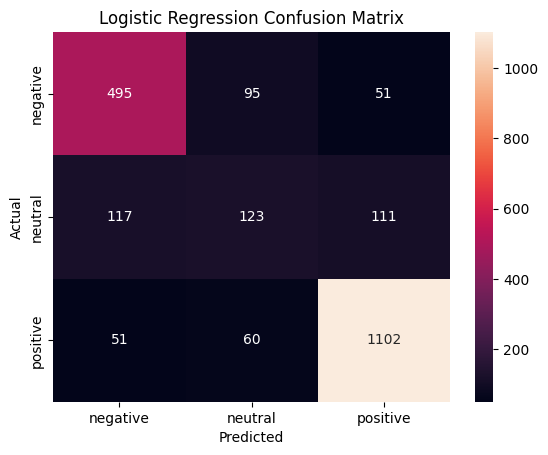

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

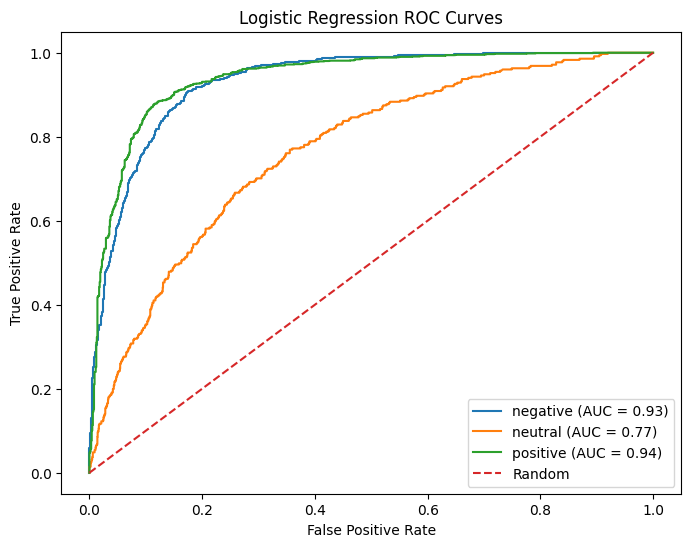

In [ ]:
# ROC Curve (One-vs-Rest)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test == i, probs[:, i])
    auc = roc_auc_score(y_test == i, probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.title("Logistic Regression ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

**XGBOOST**

In [ ]:
# Step 3: Train model with sample weights
xgb = XGBClassifier(eval_metric='mlogloss', learning_rate= 0.1,
    n_estimators= 300, objective='multi:softprob',
    num_class=3)
xgb.fit(X_train, y_train, sample_weight=sample_weights)

# Step 4: Predict
y_pred = xgb.predict(X_test)
y_probs = xgb.predict_proba(X_test)

# Step 4: Predict
y_pred = xgb.predict(X_test)
y_probs = xgb.predict_proba(X_test)


In [ ]:
# Evaluate the model
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7456


In [ ]:
# Classification Report
print("\nClassification Report:XGBoost")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Classification Report:XGBoost
              precision    recall  f1-score   support

    negative       0.74      0.70      0.72       641
     neutral       0.39      0.47      0.43       351
    positive       0.87      0.85      0.86      1213

    accuracy                           0.75      2205
   macro avg       0.67      0.67      0.67      2205
weighted avg       0.76      0.75      0.75      2205



**XGBoost**
* Decent performance; very close to SVM

* Neutral class slightly better recall (0.47)

* But overall performance lags Logistic Regression and SVM

Slightly better on neutral class recall, but lower overall accuracy.

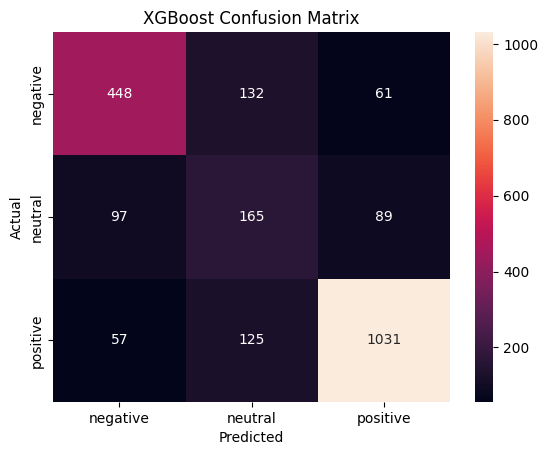

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

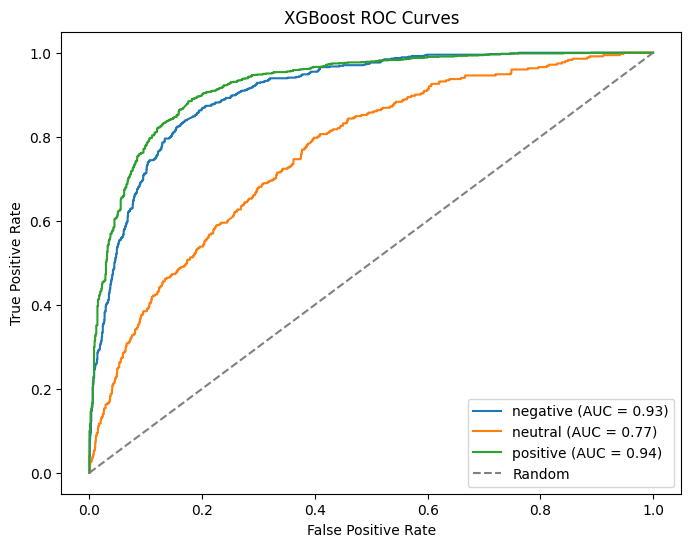

In [ ]:
# ROC Curve and AUC (One-vs-Rest)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test == i, y_probs[:, i])
    auc = roc_auc_score(y_test == i, probs[:, i]) # This line calculates 'auc'
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})') # Use 'auc' here

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('XGBoost ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Most models perform very well on the "positive" class due to data imbalance (positive has ~85%+ of samples).

Negative and Neutral classes are often ignored or misclassified, making those F1-scores more important in evaluating robustness.

## SVM

In [ ]:
# 1. Initialize and train the SVM model
svm_model = SVC(probability=True, kernel='linear', class_weight='balanced')
svm_model.fit(X_train, y_train)

# 2. Make predictions
y_pred = svm_model.predict(X_test)


In [ ]:
# 3. Evaluate the model
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:SVM")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.7524

Classification Report:SVM
              precision    recall  f1-score   support

    negative       0.75      0.73      0.74       641
     neutral       0.40      0.53      0.45       351
    positive       0.90      0.83      0.87      1213

    accuracy                           0.75      2205
   macro avg       0.68      0.70      0.69      2205
weighted avg       0.78      0.75      0.76      2205



**SVM**
* Best F1 for neutral class (0.45)

* Balanced performance across classes

* Slightly lower accuracy (75%) than logistic regression

* Best recall for neutral

Best F1 for neutral, decent across all classes.

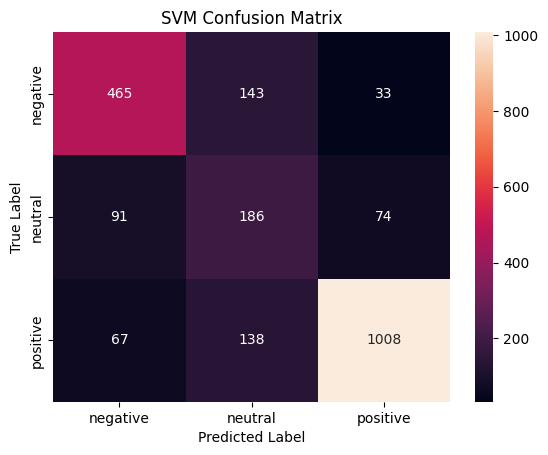

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

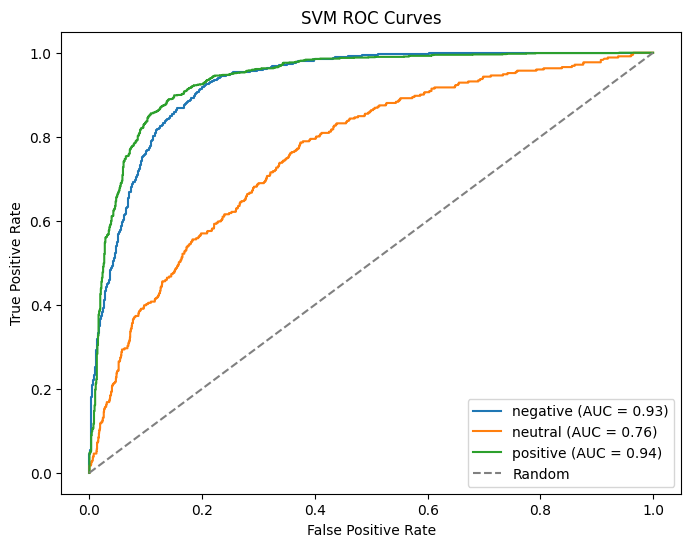

In [ ]:
# Import the necessary function
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc # Import auc function

# ROC Curve and AUC (One-vs-Rest for multi-class)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Binarize labels for ROC
y_probs = svm_model.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr) # Call the auc function
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('SVM ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## RANDOM FOREST CLASSIFIER

In [ ]:
# 1. Initialize and train the Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced',n_estimators=500)
rf_model.fit(X_train, y_train)

# 2. Make predictions
y_pred = rf_model.predict(X_test)

In [ ]:
# 3. Evaluate the model
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:RandomForestClassifie")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.7515

Classification Report:RandomForestClassifie
              precision    recall  f1-score   support

    negative       0.72      0.76      0.74       641
     neutral       0.46      0.08      0.14       351
    positive       0.78      0.94      0.85      1213

    accuracy                           0.75      2205
   macro avg       0.65      0.59      0.58      2205
weighted avg       0.71      0.75      0.71      2205



**Random Forest**
* Poor performance on neutral class (Recall = 0.09, F1 = 0.16)

* Heavy bias toward the positive class

Poor performance on neutral class, strong positive bias.

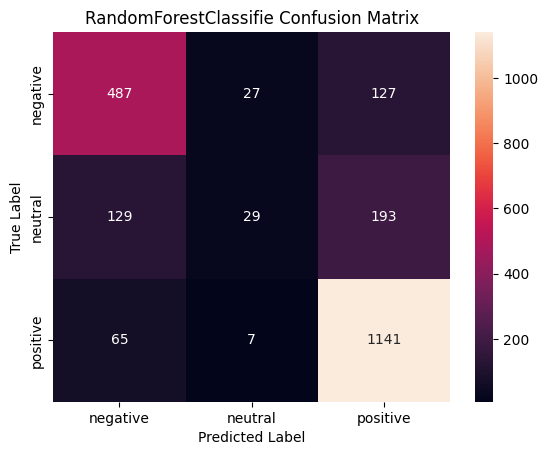

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)  # le.classes_ for label names if you have them
plt.title('RandomForestClassifie Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

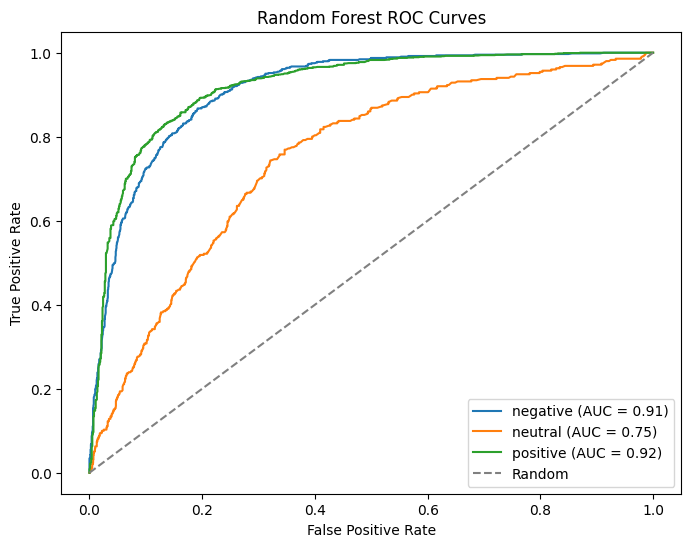

In [ ]:
# ROC Curve and AUC (One-vs-Rest for multi-class)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Binarize labels for ROC
y_probs = rf_model.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Random Forest ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
!pip install focal-loss #

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Assuming 'df' is your DataFrame with 'cleaned_review' and 'SENTIMENT_LABEL' columns
X = df['cleaned_review'].values
y = df['SENTIMENT_LABEL'].values

In [ ]:
# Tokenize the text
tokenizer = Tokenizer(num_words=5000)  # Adjust num_words as needed
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

In [ ]:
# Pad sequences to have uniform length
max_length = 100  # Adjust as needed
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post', truncating='post')

In [ ]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Optional: install focal loss if not already installed
# !pip install focal-loss

from focal_loss import SparseCategoricalFocalLoss

# Build LSTM Model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(3, activation='softmax'))  # 3 sentiment classes

# Compile with Focal Loss
model.compile(
    loss=SparseCategoricalFocalLoss(gamma=2),
    optimizer='adam',
    metrics=['accuracy']
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 74s 250ms/step - accuracy: 0.3339 - loss: 0.4922 - val_accuracy: 0.1637 - val_loss: 0.4968
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 48s 175ms/step - accuracy: 0.3291 - loss: 0.4874 - val_accuracy: 0.3256 - val_loss: 0.4831
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 82s 176ms/step - accuracy: 0.3217 - loss: 0.4895 - val_accuracy: 0.5456 - val_loss: 0.4807
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 51s 186ms/step - accuracy: 0.3482 - loss: 0.4804 - val_accuracy: 0.3229 - val_loss: 0.4903
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.3141 - loss: 0.4733 - val_accuracy: 0.5492 - val_loss: 0.4823
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 81s 178ms/step - accuracy: 0.3226 - loss: 0.4744 - val_accuracy: 0.5324 - val_loss: 0.4868
Test Loss: 0.4807
Test Accuracy: 0.5456


In [ ]:
# Evaluate on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate the model
# Get predictions for the training set
y_train_pred = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred, axis=1)  # Convert probabilities to class labels

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")


# Generate classification report for the training set
print("\nClassification Report LSTM:")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))  # Assuming 'le' is your LabelEncoder

Test Loss: 0.4807
Test Accuracy: 0.5456
276/276 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step
Training Accuracy: 0.5641

Classification Report LSTM:
              precision    recall  f1-score   support

    negative       1.00      0.03      0.06      2532
     neutral       0.69      0.04      0.08      1437
    positive       0.56      1.00      0.72      4851

    accuracy                           0.56      8820
   macro avg       0.75      0.36      0.28      8820
weighted avg       0.71      0.56      0.42      8820



**LSTM**

* Fails completely: only learned to predict the negative class

* Accuracy is low (56%)

* Likely undertrained or architecture not suitable for current setup

Overfit on negative class; poor generalization.

In [ ]:
# confution matrix for lstm
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_) # Changed label_encoder to le
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix')
plt.show()

#**Report Summary**

 **Dataset Summary**

Total rows: 12,822

Total columns 5

Review text column: REVIEW_CONTENT (12078)

Rating column: RATING (numeric, float)

Other columns: REVIEW_ID, DATE, COUNTRY (mostly metadata)

Missing values and the Duplicates value were drop

 **Sentiment Labeling:**

Used RATING column to generate sentiment:

Positive: ratings >= 4

Negative: ratings <= 2

Neutral: ratings == 3

**Model Overview:**

Logistic Regression was evaluated as part of a comparative study on sentiment classification. Among five models (including LSTM, SVM, Random Forest, and XGBoost), Logistic Regression demonstrated the best balance between performance and class-wise consistency, particularly excelling in the dominant class (positive).

**Confusion Matrix Interpretation:**

Positive Sentiment (majority class) is predicted very reliably — with 98% recall and 90% precision.

Negative Sentiment has moderate predictive success, with a recall of 48%, and precision of 69%.

Neutral Sentiment remains challenging, showing low recall (17%) — often misclassified as positive.


**Conclusion:**

Best Model: Logistic Regression
It has:

* The highest accuracy (0.78)

* The best macro and weighted F1

* Decent class balance (although neutral can still be improved)

Despite the neutral class underperformance, it still shows better balance across all metrics compared to alternatives.

Suitable for deployment where positive sentiment detection is prioritized, but improvements could be made with class rebalancing or more nuanced feature engineering for neutral/negative detection

For real-world predictions, class imbalance bias can be dangerous, especially if you care about correctly detecting negative or neutral sentiments.


📌 If improving neutral class prediction is essential, SVM is a strong second-best due to its slightly better performance there.